In [146]:
using Flux
using LinearAlgebra

function check_dim(x)
    """This function checks the appropriate  dimensions of input data"""
    if isa(x, Matrix)
        return size(x, 2)  # Returns the number of columns (width) of the matrix
    elseif isa(x, Vector)
        return 1  # Return 1 if it's a column vector
    else
        type = typeof(x)
        error("Input data type: $type is neither a matrix or column vector")
    end
end

function jac(model, x, f,param)
    """Gets the jacobian of a specific parameter"""
    jaco(f) = Flux.jacobian(() -> model(x)[f],Flux.params(model))
    return jaco(f)[Flux.params(model)[param]]
end

function Df(model, x)
    # x: single datapoint
    m = length(model(x))

    # Total amount of θ exluding final bias
    total_amount_of_θ = sum(length, Flux.params(model))  - length(Flux.params(model)[length(Flux.params(model))])

    # Skilgreini empty jacobian matrix
    Jacob = zeros(total_amount_of_θ,m)

    for func_i = 1:m
        current_col = Vector{Float64}(undef, 0) # Preallocate memory
        for param_i = 1:length(Flux.params(model)) - 1
            jac_vec = jac(model, x, func_i, param_i)[:]
            current_col = vcat(current_col, jac_vec) # Concatenate vectors
        end
        for k = 1:total_amount_of_θ 
            Jacob[k, func_i] = current_col[k]
        end
    end

    return Jacob # Þetta er Df fylkið í bilblíunni
end

function kernel(model, x)
    N = check_dim(x)
    m = length(model(x[:,1]))
    K = zeros(N*m, N*m)
    
    for i = 1:N
        for j = 1:N
            block = Df(model, x[:,i])' * Df(model, x[:,j])
            K[(i-1)*m+1:i*m, (j-1)*m+1:j*m] .= block
        end
    end
    
    return K
end


kernel (generic function with 1 method)

In [148]:
Nx=21
xa=-1.0
xb=1.0

xVec=collect(range(-1.0,stop=1.0,length=Nx));
yVec=sin.(2*pi*xVec) .+ 0.1*randn(size(xVec));  # Einhver plat gögn

n1=100_000
W=randn(n1,1);  #Modelling N(0,1) distributed W^[1]
b=randn(n1,1);  #Modelling N(0,1) distributed b^[0]
W0=randn(1,n1); #Modelling N(0,1) distributed W^[0]

my_sigm = Chain(Dense(1,n1,sigmoid), Dense(n1,1))
my_relu = Chain(Dense(1,n1,relu), Dense(n1,1))
my_tanh = Chain(Dense(1,n1,tanh), Dense(n1,1))


Chain(
  Dense(1 => 100000, tanh),             # 200_000 parameters
  Dense(100000 => 1),                   # 100_001 parameters
)                   # Total: 4 arrays, 300_001 parameters, 1.145 MiB.

In [149]:
W=randn(n1,1);  #Modelling N(0,1) distributed W^[1]
b=randn(n1,1);  #Modelling N(0,1) distributed b^[0]
W0=randn(1,n1); #Modelling N(0,1) distributed W^[0]

p(model,x) = Flux.params(model)[x]

p(my_sigm, 1) .= W; p(my_relu, 1) .= W; p(my_tanh, 1) .= W; 
p(my_sigm, 2) .= b; p(my_relu, 2) .= b; p(my_tanh, 2) .= b
p(my_sigm, 3) .=W0; p(my_relu, 3) .=W0; p(my_tanh, 3) .=W0;


In [150]:
K_sigm = kernel(my_sigm, hcat(xVec...))
K_relu = kernel(my_relu, hcat(xVec...))
K_tanh = kernel(my_tanh, hcat(xVec...))

21×21 Matrix{Float64}:
     1.21717e5      1.1852e5   …   4803.61           36.9408
     1.1852e5       1.16078e5      9452.13         4813.77
     1.14639e5      1.12967e5     14448.3          9946.7
     1.10059e5      1.09149e5     19804.5         15449.2
     1.04794e5      1.04614e5     25525.6         21327.7
 98893.3        99390.0        …  31606.3         27578.9
 92433.3        93540.7           38027.4         34186.4
 85515.9        87161.4           44753.2         41118.2
 78258.6        80370.8           51730.0         48325.3
 70786.2        73299.8           58884.7         55740.9
     ⋮                         ⋱                      ⋮
 48265.5        51681.7           80417.5         78322.0
 41061.2        44706.9           87217.4         85589.2
 34135.0        37986.1           93615.5         92524.7
 27535.0        31572.4        …  99494.0         99011.7
 21292.1        25499.9               1.04755e5  104946.0
 15421.8        19787.1               1.09327e5

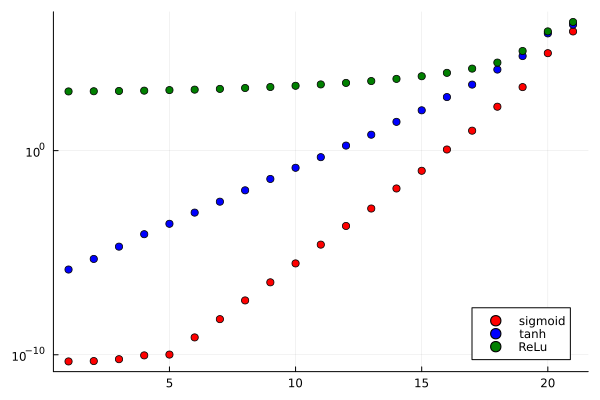

In [152]:
using Plots

scatter(abs.(eigen(K_sigm).values),label="sigmoid",color="red",yaxis=:log10,key=:bottomright)
scatter!(abs.(eigen(K_tanh).values),label="tanh",color="blue")
scatter!(abs.(eigen(K_relu).values),label="ReLu",color="green")

<h1>Skoðum nú nokkur plot</h1>